In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2
import glob

In [2]:
def load_data(image_dir, is_tumor, size=(128, 128)):
    images, masks = [], []
    for img_path in glob.glob(os.path.join(image_dir, '*.jpg')):  # Adjust file type if needed
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load grayscale MRI
        img = cv2.resize(img, size) / 255.0  # Normalize to [0, 1]
        if is_tumor:  # For tumor images, create masks (synthetic in this example)
            mask = np.zeros(size)  # Create a blank mask
            mask[32:96, 32:96] = 1.0  # Simulate a tumor mask for the example
        else:
            mask = np.zeros(size)  # No tumor = blank mask
        images.append(img)
        masks.append(mask)
    return np.array(images).reshape(-1, size[0], size[1], 1), np.array(masks).reshape(-1, size[0], size[1], 1)

# Paths to dataset
tumor_path = 'Brain MRI Images/yes'
no_tumor_path = 'Brain MRI Images/no'

# Load Data
tumor_images, tumor_masks = load_data(tumor_path, is_tumor=True)
no_tumor_images, no_tumor_masks = load_data(no_tumor_path, is_tumor=False)

# Combine Data
images = np.concatenate([tumor_images, no_tumor_images], axis=0)
masks = np.concatenate([tumor_masks, no_tumor_masks], axis=0)

# Split Data
x_train, x_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [3]:
# Define the U-Net model
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)
    
    # Downsampling
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    
    # Upsampling
    u5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [4]:
# Initialize and train the model
model = unet_model()
model.fit(
    x_train, y_train,
    epochs=15,  # Increased epochs for better training
    batch_size=16,
    validation_data=(x_val, y_val)
)

# Save the trained model
model.save('brain_tumor_highlight_model.h5')

Epoch 1/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.6801 - loss: 0.7196 - val_accuracy: 0.8714 - val_loss: 0.5341
Epoch 2/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8655 - loss: 0.4754 - val_accuracy: 0.8714 - val_loss: 0.4160
Epoch 3/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 24s 3s/step - accuracy: 0.8817 - loss: 0.3304 - val_accuracy: 0.8714 - val_loss: 0.2933
Epoch 4/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8754 - loss: 0.2434 - val_accuracy: 0.8714 - val_loss: 0.2921
Epoch 5/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8696 - loss: 0.2525 - val_accuracy: 0.8714 - val_loss: 0.2782
Epoch 6/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8834 - loss: 0.2308 - val_accuracy: 0.8714 - val_loss: 0.3005
Epoch 7/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 23s 3s/step - accuracy: 0.8590 - loss: 0.2721 - val_accuracy: 0.8714 - val_loss: 0.2655
Epoch 8/15
9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.8826 - loss: 0.2239 - val_accuracy: 0.8714 - val_loss: 0.2528
Epoch 9/

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


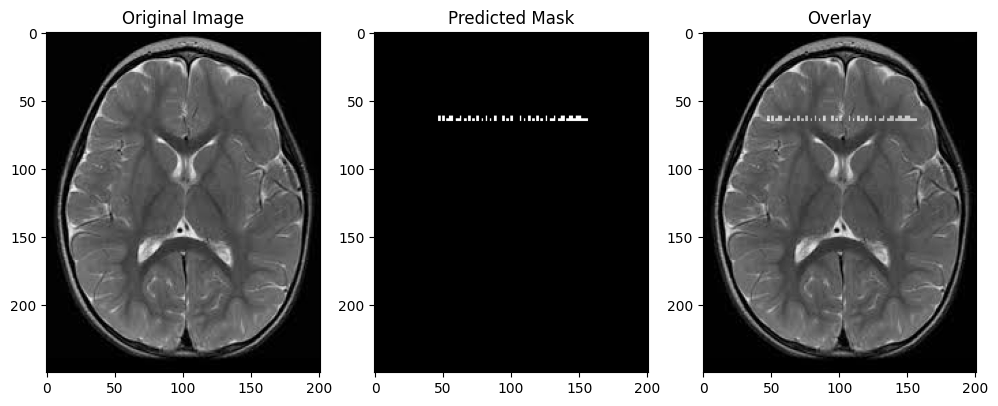

In [15]:
def predict_and_visualize(image_path, model, size=(128, 128)):
    # Preprocess the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    original_size = img.shape
    img_resized = cv2.resize(img, size) / 255.0
    img_resized = np.expand_dims(img_resized, axis=-1)
    img_resized = np.expand_dims(img_resized, axis=0)

    # Predict the tumor mask
    predicted_mask = model.predict(img_resized)[0]
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Resize the mask back to the original size
    mask_resized = cv2.resize(predicted_mask, original_size[::-1])
    
    # Overlay the mask on the original image
    overlay = cv2.addWeighted(img, 0.7, mask_resized * 255, 0.3, 0)

    # Display the results
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(img, cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title('Predicted Mask')
    plt.imshow(mask_resized, cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title('Overlay')
    plt.imshow(overlay, cmap='gray')

    plt.show()

# Test the model
model = load_model('brain_tumor_highlight_model.h5')
predict_and_visualize('Brain MRI Images/brain_tumor_dataset/no/n5.jpg', model)